Flux with MNIST and GPU


Libraries

In [57]:
using CUDA

using MLDatasets           # mnist
using PreprocessingImages; pim = PreprocessingImages

using MLDataUtils          # label, nlabel, labelfreq, stratifiedobs
using Flux                 # the julia ml library

using Random

In [58]:
include( expanduser("~/projects/pesquisa/libs/libml.jl") )

df2FluxMatrix (generic function with 1 method)

MNIST

In [59]:
# load mnist
datasetX,    datasetY    = MNIST(:train)[:]
validationX, validationY = MNIST(:test)[:];

In [60]:
# split trainset, testset from dataset
Random.seed!(1)
(trainX, trainY), (testX, testY) = MLDataUtils.stratifiedobs((datasetX, datasetY), p = 0.7)
size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

Preprocessing

Flux primarily works with matrices and vectors

In [61]:
function preprocess(X, y)
    Xs = permutedims(X, (2, 1, 3))
    Xs = Xs |> Flux.flatten
    
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X_c, y_c = preprocess(trainX, trainY)
d, N, typeof(X_c), size(X_c), size(y_c)

(784, 42001, Matrix{Float32}, (784, 42001), (10, 42001))

Model

In [62]:
# data on gpu
X_g = X_c |> gpu
y_g = y_c |> gpu
typeof(X_g), size(X_g), size(y_g)

(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, (784, 42001), (10, 42001))

In [63]:
# model configuration
nInputs  = d
nOutputs = 10

# Flux.Dense(nInputs, 256, tanh)
model = Chain( Dense(nInputs => 128, relu),
               Dense(128     => 32,  relu),
               Dense(32      => nOutputs),
               softmax)      |> gpu           # weights on gpu

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 32, relu),               # 4_128 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 104_938 parameters, 856 bytes.

In [64]:
lossFunction(X, y) = Flux.mse( model(X), y )
modelParameters    = Flux.params(model)
dataset            = Flux.DataLoader((X_g, y_g), batchsize=32)       # batchsize=1 => SGD, batch size > 1 => batch gradient descent
modelOptimizer     = Flux.Descent()
callBack           = Flux.throttle(() -> println("."), 10);   # print every 10s

Training

In [65]:
numberOfEpochs = 5

5

Training method without plotting epochs

In [66]:
# # https://fluxml.ai/Flux.jl/stable/training/training/

# # preferred for multiple epochs
# epochs = 1:numberOfEpochs
# for epoch in epochs
#     Flux.train!(lossFunction, modelParameters, data, modelOptimizer; cb=callBack)
# end

Training epoch with plotting, with the aid of homemade function trainModel!

In [67]:
# https://fluxml.ai/Flux.jl/stable/training/training/

epochs     = 1 : numberOfEpochs
lossVector = Vector{Float64}()
minLoss    = 1e-6   # hint: start at 1e-2, then go lower for more epochs (5e-4)
nearZero   = minLoss / 25

for epoch in epochs
    # train epoch
    loss = trainModel!( lossFunction, modelParameters, dataset, modelOptimizer )   # libml
    push!(lossVector, loss)
    print(".")   # "epoch completed" indicator

    # exit criteria
    if stopTrainingCriteria(lossVector, minLoss, nearZero)   break   end
end

.

.

.

..

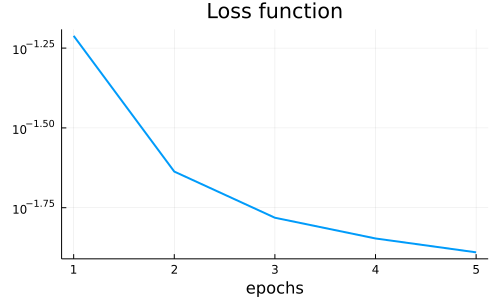

In [68]:
# plot training
plotLoss(lossVector, (500,300))

Testing

In [69]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end

predictOutcome (generic function with 1 method)

In [70]:
# preprocessing
ts_X, ts_y = preprocess(testX, testY)
X_g        = ts_X |> gpu

# predict
ŷ = predictOutcome(X_g)

# result
printMetrics( ŷ, coerce(testY, OrderedFactor) )

10×10 Matrix{Int64}:
 1711     0    16     7     2    20    17     4    10    11
    0  1964     8     4     4    15     2    11    34     3
    5    14  1587    39     5    14    11    26    28     6
    7     8    37  1650     6    67     0    16    78    38
    6     2    25     0  1623    32    12    23     7    42
    8     8     9    62     1  1389    21     2    53    12
   17     3    37     6    23    36  1705     1    25     1
    3     7    30    33     5    13     0  1759    17    51
   15    13    25    19    14    30     7     1  1467    11
    5     4    13    19    70    10     0    36    36  1610

accuracy: 0.915
f1-score: 0.913
